# Compare precipitation, refreezing, melt, and thickness changes

Author: Ziqi Yin

Last modified: 2024 Dec 17

Table of contents:
* [Maps of the difference of annual mean precipitation, refreezing, melt, and thickness changes over the GrIS](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

### Read data

In [3]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'] #[mm/s]
f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'] #[mm/s]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT']
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]
f09_lon = f09_nohacks_1pctCO2_SNOW_yearly.lon
f09_lat = f09_nohacks_1pctCO2_SNOW_yearly.lat

# 4xext
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'] #[mm/s]
f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'] #[mm/s]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]

In [4]:
# piControl
f09_nohacks_piControl_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_piControl_yearly.nc')['thk']
f09_nohacks_piControl_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_piControl_yearly.nc')['ice_sheet_mask']

# 1pctCO2
f09_nohacks_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_1pctCO2_yearly.nc')['thk']
f09_nohacks_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

# 4xext
f09_nohacks_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_4xext_yearly.nc')['thk']
f09_nohacks_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']
f09_nohacks_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_4xext_yearly.nc')['topg']
cism_x1 = f09_nohacks_4xext_thk_yearly.x1
cism_y1 = f09_nohacks_4xext_thk_yearly.y1

In [5]:
## BG iteration 7
BG7_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_thk_yearly.nc')['thk']
BG7_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_ice_sheet_mask_yearly.nc')['ice_sheet_mask']

In [6]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140] #[mm/s]
f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140] #[mm/s]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]

# 4xext
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW'] #[mm/s]
f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN'] #[mm/s]
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

In [7]:
# 1pctCO2
f09_1pctCO2_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.thk.0001-0161.nc')['thk'][1:141,:,:]
f09_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ice_sheet_mask.0001-0161.nc')['ice_sheet_mask'][1:141,:,:]

# 4xext
f09_4xext_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.thk.0141-0351.nc')['thk'][1:,:,:]
f09_4xext_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.ice_sheet_mask.0141-0351.nc')['ice_sheet_mask'][1:,:,:]
f09_4xext_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.topg.0141-0351.nc')['topg'][1:,:,:]

In [8]:
## arctic
# 1pctCO2
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] #[mm/s]
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] #[mm/s]
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT']
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']

# 4xext
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW'] #[mm/s]
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN'] #[mm/s]
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

In [9]:
# piControl
ARCTIC_piControl_p4_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_piControl_p4_yearly.nc')['thk']
ARCTIC_piControl_p4_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_piControl_p4_yearly.nc')['ice_sheet_mask']

# 1pctCO2
ARCTIC_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_1pctCO2_yearly.nc')['thk']
ARCTIC_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

# 4xext
ARCTIC_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_4xext_yearly.nc')['thk']
ARCTIC_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']
ARCTIC_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_4xext_yearly.nc')['topg']

In [10]:
## Calculate total precipitation, melt, and refreezing
f09_nohacks_1pctCO2_precip_yearly = f09_nohacks_1pctCO2_SNOW_yearly + f09_nohacks_1pctCO2_RAIN_yearly
f09_nohacks_4xext_precip_yearly = f09_nohacks_4xext_SNOW_yearly + f09_nohacks_4xext_RAIN_yearly
f09_nohacks_1pctCO2_4xext_precip_yearly = xr.concat([f09_nohacks_1pctCO2_precip_yearly, f09_nohacks_4xext_precip_yearly], dim='time')
f09_nohacks_1pctCO2_melt_yearly = f09_nohacks_1pctCO2_QICE_MELT_yearly + f09_nohacks_1pctCO2_QSNOMELT_yearly
f09_nohacks_4xext_melt_yearly = f09_nohacks_4xext_QICE_MELT_yearly + f09_nohacks_4xext_QSNOMELT_yearly
f09_nohacks_1pctCO2_4xext_melt_yearly = xr.concat([f09_nohacks_1pctCO2_melt_yearly, f09_nohacks_4xext_melt_yearly], dim='time')
f09_nohacks_1pctCO2_refrz_yearly = f09_nohacks_1pctCO2_melt_yearly + f09_nohacks_1pctCO2_RAIN_yearly - f09_nohacks_1pctCO2_QRUNOFF_yearly
f09_nohacks_4xext_refrz_yearly = f09_nohacks_4xext_melt_yearly + f09_nohacks_4xext_RAIN_yearly - f09_nohacks_4xext_QRUNOFF_yearly
f09_nohacks_1pctCO2_4xext_refrz_yearly = xr.concat([f09_nohacks_1pctCO2_refrz_yearly, f09_nohacks_4xext_refrz_yearly], dim='time')

f09_1pctCO2_precip_yearly = f09_1pctCO2_SNOW_yearly + f09_1pctCO2_RAIN_yearly
f09_4xext_precip_yearly = f09_4xext_SNOW_yearly + f09_4xext_RAIN_yearly
f09_1pctCO2_4xext_precip_yearly = xr.concat([f09_1pctCO2_precip_yearly, f09_4xext_precip_yearly], dim='time')
f09_1pctCO2_melt_yearly = f09_1pctCO2_QICE_MELT_yearly + f09_1pctCO2_QSNOMELT_yearly
f09_4xext_melt_yearly = f09_4xext_QICE_MELT_yearly + f09_4xext_QSNOMELT_yearly
f09_1pctCO2_4xext_melt_yearly = xr.concat([f09_1pctCO2_melt_yearly, f09_4xext_melt_yearly], dim='time')
f09_1pctCO2_refrz_yearly = f09_1pctCO2_melt_yearly + f09_1pctCO2_RAIN_yearly - f09_1pctCO2_QRUNOFF_yearly
f09_4xext_refrz_yearly = f09_4xext_melt_yearly + f09_4xext_RAIN_yearly - f09_4xext_QRUNOFF_yearly
f09_1pctCO2_4xext_refrz_yearly = xr.concat([f09_1pctCO2_refrz_yearly, f09_4xext_refrz_yearly], dim='time')

ARCTIC_1pctCO2_precip_yearly = ARCTIC_1pctCO2_SNOW_yearly + ARCTIC_1pctCO2_RAIN_yearly
ARCTIC_4xext_precip_yearly = ARCTIC_4xext_SNOW_yearly + ARCTIC_4xext_RAIN_yearly
ARCTIC_1pctCO2_4xext_precip_yearly = xr.concat([ARCTIC_1pctCO2_precip_yearly, ARCTIC_4xext_precip_yearly], dim='time')
ARCTIC_1pctCO2_melt_yearly = ARCTIC_1pctCO2_QICE_MELT_yearly + ARCTIC_1pctCO2_QSNOMELT_yearly
ARCTIC_4xext_melt_yearly = ARCTIC_4xext_QICE_MELT_yearly + ARCTIC_4xext_QSNOMELT_yearly
ARCTIC_1pctCO2_4xext_melt_yearly = xr.concat([ARCTIC_1pctCO2_melt_yearly, ARCTIC_4xext_melt_yearly], dim='time')
ARCTIC_1pctCO2_refrz_yearly = ARCTIC_1pctCO2_melt_yearly + ARCTIC_1pctCO2_RAIN_yearly - ARCTIC_1pctCO2_QRUNOFF_yearly
ARCTIC_4xext_refrz_yearly = ARCTIC_4xext_melt_yearly + ARCTIC_4xext_RAIN_yearly - ARCTIC_4xext_QRUNOFF_yearly
ARCTIC_1pctCO2_4xext_refrz_yearly = xr.concat([ARCTIC_1pctCO2_refrz_yearly, ARCTIC_4xext_refrz_yearly], dim='time')


In [11]:
## Concat
f09_nohacks_1pctCO2_4xext_thk_yearly = xr.concat([f09_nohacks_1pctCO2_thk_yearly, f09_nohacks_4xext_thk_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([f09_nohacks_1pctCO2_ice_sheet_mask_yearly, f09_nohacks_4xext_ice_sheet_mask_yearly], dim='time')
f09_1pctCO2_4xext_thk_yearly = xr.concat([f09_1pctCO2_thk_yearly, f09_4xext_thk_yearly], dim='time')
f09_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([f09_1pctCO2_ice_sheet_mask_yearly, f09_4xext_ice_sheet_mask_yearly], dim='time')
ARCTIC_1pctCO2_4xext_thk_yearly = xr.concat([ARCTIC_1pctCO2_thk_yearly, ARCTIC_4xext_thk_yearly], dim='time')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([ARCTIC_1pctCO2_ice_sheet_mask_yearly, ARCTIC_4xext_ice_sheet_mask_yearly], dim='time')

In [12]:
## Mean of all 350 years
f09_nohacks_precip_all = f09_nohacks_1pctCO2_4xext_precip_yearly[:,:,:].mean(dim='time')
f09_nohacks_melt_all = f09_nohacks_1pctCO2_4xext_melt_yearly[:,:,:].mean(dim='time')
f09_nohacks_refrz_all = f09_nohacks_1pctCO2_4xext_refrz_yearly[:,:,:].mean(dim='time')

f09_precip_all = f09_1pctCO2_4xext_precip_yearly[:,:,:].mean(dim='time')
f09_melt_all = f09_1pctCO2_4xext_melt_yearly[:,:,:].mean(dim='time')
f09_refrz_all = f09_1pctCO2_4xext_refrz_yearly[:,:,:].mean(dim='time')

ARCTIC_precip_all = ARCTIC_1pctCO2_4xext_precip_yearly[:,:].mean(dim='time')
ARCTIC_melt_all = ARCTIC_1pctCO2_4xext_melt_yearly[:,:].mean(dim='time')
ARCTIC_refrz_all = ARCTIC_1pctCO2_4xext_refrz_yearly[:,:].mean(dim='time')

In [13]:
## Masked by ice_sheet_mask (eliminate e.g., small ice caps)
f09_nohacks_piControl_thk_yearly_masked = f09_nohacks_piControl_ice_sheet_mask_yearly.where(f09_nohacks_piControl_ice_sheet_mask_yearly>0) * f09_nohacks_piControl_thk_yearly
f09_nohacks_1pctCO2_4xext_thk_yearly_masked = f09_nohacks_1pctCO2_4xext_ice_sheet_mask_yearly.where(f09_nohacks_1pctCO2_4xext_ice_sheet_mask_yearly>0) * f09_nohacks_1pctCO2_4xext_thk_yearly
BG7_thk_yearly_masked = BG7_ice_sheet_mask_yearly.where(BG7_ice_sheet_mask_yearly>0) * BG7_thk_yearly
f09_1pctCO2_4xext_thk_yearly_masked = f09_1pctCO2_4xext_ice_sheet_mask_yearly.where(f09_1pctCO2_4xext_ice_sheet_mask_yearly>0) * f09_1pctCO2_4xext_thk_yearly
ARCTIC_piControl_p4_thk_yearly_masked = ARCTIC_piControl_p4_ice_sheet_mask_yearly.where(ARCTIC_piControl_p4_ice_sheet_mask_yearly>0) * ARCTIC_piControl_p4_thk_yearly
ARCTIC_1pctCO2_4xext_thk_yearly_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly.where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly>0) * ARCTIC_1pctCO2_4xext_thk_yearly

In [14]:
## Select
f09_nohacks_thk_PI = f09_nohacks_piControl_thk_yearly_masked[-20:,:,:].mean(dim='time')
f09_nohacks_thk_end = f09_nohacks_1pctCO2_4xext_thk_yearly_masked[-20:,:,:].mean(dim='time')
f09_nohacks_4xext_topg_yearly_y350 = f09_nohacks_4xext_topg_yearly[-1,:,:]

f09_thk_PI = BG7_thk_yearly_masked[129:149,:,:].mean(dim='time')
f09_thk_end = f09_1pctCO2_4xext_thk_yearly_masked[-20:,:,:].mean(dim='time')
f09_4xext_topg_yearly_y350 = f09_4xext_topg_yearly[-1,:,:]

ARCTIC_thk_PI = ARCTIC_piControl_p4_thk_yearly_masked[-20:,:,:].mean(dim='time')
ARCTIC_thk_end = ARCTIC_1pctCO2_4xext_thk_yearly_masked[-20:,:,:].mean(dim='time')
ARCTIC_4xext_topg_yearly_y350 = ARCTIC_4xext_topg_yearly[-1,:,:]

In [15]:
## Calculate changes
f09_nohacks_dthk_end_PI = f09_nohacks_thk_end - f09_nohacks_thk_PI
f09_dthk_end_PI = f09_thk_end - f09_thk_PI
ARCTIC_dthk_end_PI = ARCTIC_thk_end - ARCTIC_thk_PI

### Regrid ARCTIC to f09

In [16]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [17]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [18]:
ESMF.Manager(debug=True);

In [19]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1
    
    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [20]:
ARCTIC2f09_precip_all = f09_precip_all * 0
ARCTIC2f09_melt_all = f09_melt_all * 0
ARCTIC2f09_refrz_all = f09_refrz_all * 0

ARCTIC2f09_precip_all[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_precip_all, f09_centers, f09_corners)
ARCTIC2f09_melt_all[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_melt_all, f09_centers, f09_corners)
ARCTIC2f09_refrz_all[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_refrz_all, f09_centers, f09_corners)

### Calculate

In [27]:
## Calculate difference
ARCTIC_f09_precip_diff_all = ARCTIC2f09_precip_all - f09_precip_all
ARCTIC_f09_nohacks_precip_diff_all = ARCTIC2f09_precip_all - f09_nohacks_precip_all
ARCTIC_f09_melt_diff_all = ARCTIC2f09_melt_all - f09_melt_all
ARCTIC_f09_nohacks_melt_diff_all = ARCTIC2f09_melt_all - f09_nohacks_melt_all
ARCTIC_f09_refrz_diff_all = ARCTIC2f09_refrz_all - f09_refrz_all
ARCTIC_f09_nohacks_refrz_diff_all = ARCTIC2f09_refrz_all - f09_nohacks_refrz_all
ARCTIC_f09_dthk_diff = ARCTIC_dthk_end_PI - f09_dthk_end_PI
ARCTIC_f09_nohacks_dthk_diff = ARCTIC_dthk_end_PI - f09_nohacks_dthk_end_PI

In [28]:
## Add cyclic points
ARCTIC_f09_precip_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_precip_diff_all, coord=f09_lon)
ARCTIC_f09_nohacks_precip_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_precip_diff_all, coord=f09_lon)
ARCTIC_f09_melt_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_melt_diff_all, coord=f09_lon)
ARCTIC_f09_nohacks_melt_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_melt_diff_all, coord=f09_lon)
ARCTIC_f09_refrz_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_refrz_diff_all, coord=f09_lon)
ARCTIC_f09_nohacks_refrz_diff_all2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_refrz_diff_all, coord=f09_lon)

### Plot

In [23]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

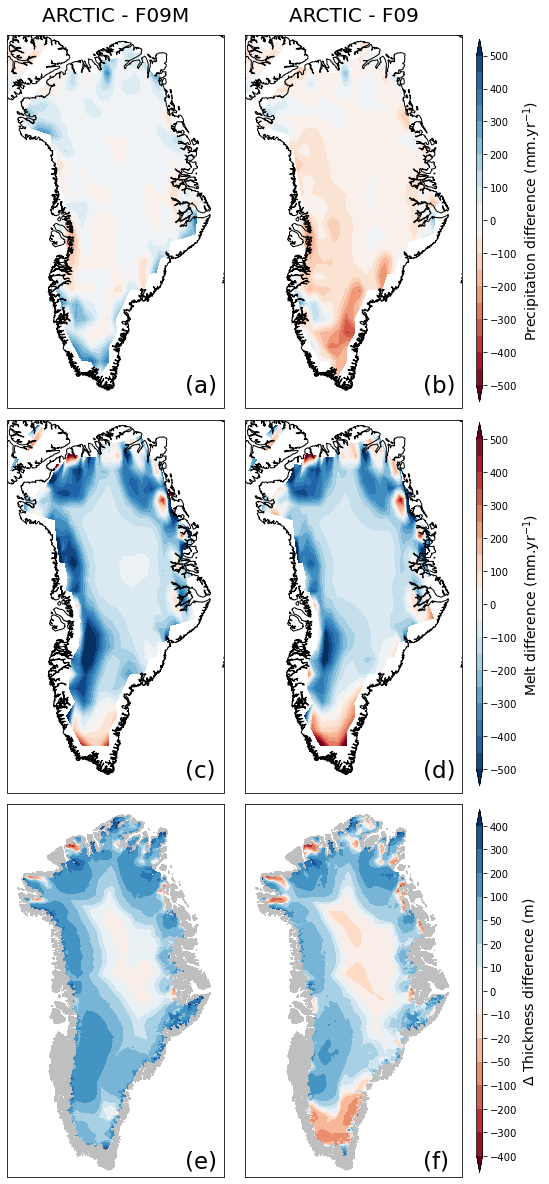

In [27]:
fig = plt.figure(figsize = (8.15,21))
gs=GridSpec(3,2)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu
bounds1 = np.arange(-500.,500.1,50.)
bounds1min = [-10000]
bounds1max = [10000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-500.,500.1,100.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,50.)
bounds2min = [-10000]
bounds2max = [10000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

cmap3 = plt.cm.RdBu
bounds3 = [-400, -300, -200, -100, -50, -20, -10, 0, 10, 20, 50, 100, 200, 300, 400]
norm3 = colors.BoundaryNorm(bounds3, cmap3.N, extend='both')

#---------------------------------------------melt----------------------------------------------------
#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_precip_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize = 20)
ax1.text(650000, -3360000, '(a)', fontsize=23)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_precip_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize = 20)
ax2.text(650000, -3360000, '(b)', fontsize=23)

# colorbar
cbar_ax2 = fig.add_axes([0.925, 0.6375, 0.01, 0.24])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb2.set_label(label='Precipitation difference (mm.$\mathregular{yr^{-1}}$)', size=14)
cb2.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_melt_diff_all2*3600*24*365, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3.text(650000, -3360000, '(c)', fontsize=23)

ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_melt_diff_all2*3600*24*365, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(650000, -3360000, '(d)', fontsize=23)

# colorbar
cbar_ax4 = fig.add_axes([0.925, 0.3836, 0.01, 0.24])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb4.set_label(label='Melt difference (mm.$\mathregular{yr^{-1}}$)', size=14)
cb4.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax5 = plt.subplot(gs[4])
im5 = ax5.contourf(cism_x1, cism_y1, f09_4xext_topg_yearly_y350.where(f09_4xext_topg_yearly_y350>0).where(f09_4xext_topg_yearly_y350<0, other=1), cmap='gray_r')
im5 = ax5.contourf(cism_x1, cism_y1, ARCTIC_f09_dthk_diff, cmap=cmap3, norm=norm3, levels=bounds3, extend='both')
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(650000, -3330000, '(e)', fontsize=23)

ax6 = plt.subplot(gs[5])
im6 = ax6.contourf(cism_x1, cism_y1, f09_nohacks_4xext_topg_yearly_y350.where(f09_nohacks_4xext_topg_yearly_y350>0).where(f09_nohacks_4xext_topg_yearly_y350<0, other=1), cmap='gray_r')
im6 = ax6.contourf(cism_x1, cism_y1, ARCTIC_f09_nohacks_dthk_diff, cmap=cmap3, norm=norm3, levels=bounds3, extend='both')
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(650000, -3330000, '(f)', fontsize=23)

# colorbar
cbar_ax6 = fig.add_axes([0.925, 0.128, 0.01, 0.24])
cb = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=[-1300]+bounds3+[1300], ticks=bounds3)
cb.set_label(label=r'$\Delta$ Thickness difference (m)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_precip_melt_dthk_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

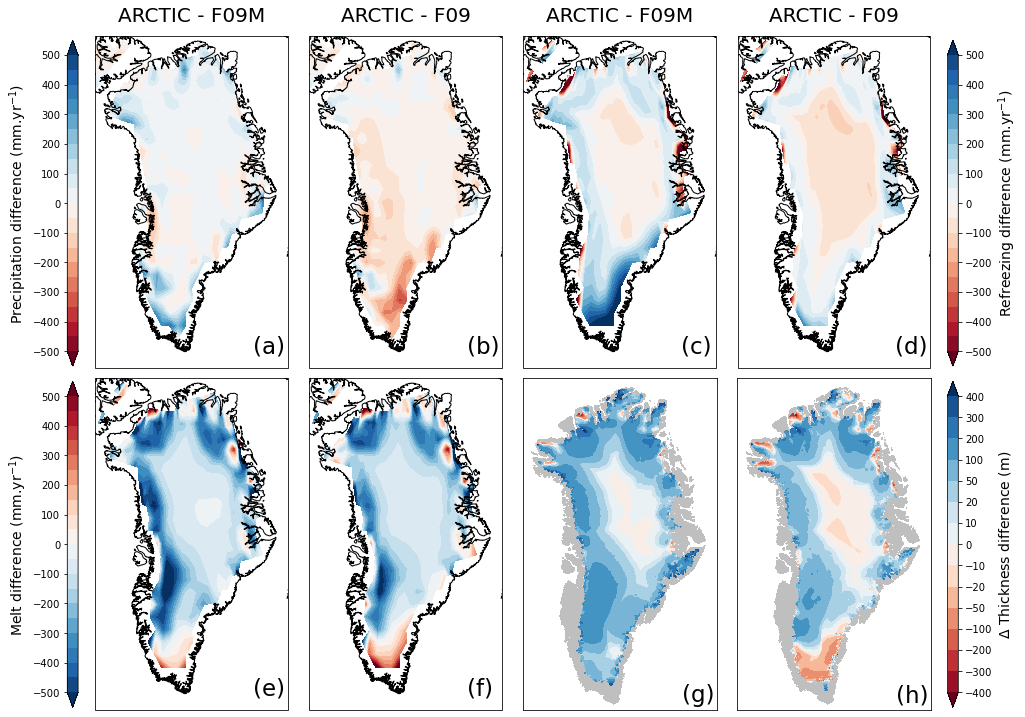

In [38]:
# Add refreezing
fig = plt.figure(figsize = (15,12.4))
gs=GridSpec(2,4)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu
bounds1 = np.arange(-500.,500.1,50.)
bounds1min = [-10000]
bounds1max = [10000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-500.,500.1,100.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,50.)
bounds2min = [-10000]
bounds2max = [10000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

cmap3 = plt.cm.RdBu
bounds3 = [-400, -300, -200, -100, -50, -20, -10, 0, 10, 20, 50, 100, 200, 300, 400]
norm3 = colors.BoundaryNorm(bounds3, cmap3.N, extend='both')

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_precip_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize = 20)
ax1.text(650000, -3360000, '(a)', fontsize=23)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_precip_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize = 20)
ax2.text(650000, -3360000, '(b)', fontsize=23)

# colorbar
cbar_ax2 = fig.add_axes([0.1, 0.51, 0.01, 0.365])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb2.set_label(label='Precipitation difference (mm.$\mathregular{yr^{-1}}$)', size=14)
cb2.ax.tick_params(labelsize=10)
cb2.ax.yaxis.set_ticks_position('left')
cb2.ax.yaxis.set_label_position('left')

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_refrz_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize = 20)
ax3.text(650000, -3360000, '(c)', fontsize=23)

ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_refrz_diff_all2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize = 20)
ax4.text(650000, -3360000, '(d)', fontsize=23)

# colorbar
cbar_ax4 = fig.add_axes([0.915, 0.51, 0.01, 0.365])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb4.set_label(label='Refreezing difference (mm.$\mathregular{yr^{-1}}$)', size=14)
cb4.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax5 = plt.subplot(gs[4], projection=polar_stereographic)
ax5.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, ARCTIC_f09_melt_diff_all2*3600*24*365, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(650000, -3360000, '(e)', fontsize=23)

ax6 = plt.subplot(gs[5], projection=polar_stereographic)
ax6.set_extent([-56.5, -29.5, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_melt_diff_all2*3600*24*365, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(650000, -3360000, '(f)', fontsize=23)

# colorbar
cbar_ax6 = fig.add_axes([0.1, 0.128, 0.01, 0.365])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Melt difference (mm.$\mathregular{yr^{-1}}$)', size=14)
cb6.ax.tick_params(labelsize=10)
cb6.ax.yaxis.set_ticks_position('left')
cb6.ax.yaxis.set_label_position('left')

ax7 = plt.subplot(gs[6])
im7 = ax7.contourf(cism_x1, cism_y1, f09_4xext_topg_yearly_y350.where(f09_4xext_topg_yearly_y350>0).where(f09_4xext_topg_yearly_y350<0, other=1), cmap='gray_r')
im7 = ax7.contourf(cism_x1, cism_y1, ARCTIC_f09_dthk_diff, cmap=cmap3, norm=norm3, levels=bounds3, extend='both')
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(650000, -3330000, '(g)', fontsize=23)

ax8 = plt.subplot(gs[7])
im8 = ax8.contourf(cism_x1, cism_y1, f09_nohacks_4xext_topg_yearly_y350.where(f09_nohacks_4xext_topg_yearly_y350>0).where(f09_nohacks_4xext_topg_yearly_y350<0, other=1), cmap='gray_r')
im8 = ax8.contourf(cism_x1, cism_y1, ARCTIC_f09_nohacks_dthk_diff, cmap=cmap3, norm=norm3, levels=bounds3, extend='both')
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(650000, -3330000, '(h)', fontsize=23)

# colorbar
cbar_ax8 = fig.add_axes([0.915, 0.128, 0.01, 0.365])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=[-1300]+bounds3+[1300], ticks=bounds3)
cb8.set_label(label=r'$\Delta$ Thickness difference (m)', size=14)
cb8.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_precip_refrz_melt_dthk_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)